### Soma Vasuthevan (SV1168) & Demetrius Beckham (DAB614)

#### Questions 

1. Can a program accurately analyze the sentiment of textual news?
2. Can we build a profitable trading strategy on sentiment analysis?

#### Goals 

1. Programmatically analyze the sentiment of market moving news and return a positive/negative signal. 
2. Implement a trading strategy that goes long a stock if the sentiment analysis is positive and goes short if the sentiment is negative.
3. Evaluate the performance of the sentiment analysis program by calculating the returns of the strategy. 

#### Data (must be "new" news) 

Although the inspiration for the project was Kylie Jenner's tweet regarding Snapchat, we have decided to avoid social media and traditional news reports because it would be difficult to determine if the news is "new" or already reported in other sources and therefore may not be market moving. This project will focus on corporate releases which tend to be "new" and material information at the date of release. If the sentiment analyzer is effective we could deploy it on live social media and news events in the future.

###### Earnings Call Transcripts 

We will be using earnings call transcripts from 2002 - 2005 to test the sentiment analysis program. Files are available here: 

https://www.dropbox.com/sh/2tjbi4iika8z2kc/AAD_AoogWEpTjwXpsvjs0Z8Sa


#### Methodology:

##### 1. Read in transcripts, stop words list and sentiment dictionary

Reading in google drive files. Program will request for google account authentication. Ensure pop ups are enabled.

1. Transcripts: https://drive.google.com/open?id=1TYF4sZ53LZdYFpbrE9KvNib59X7lV6Lc
2. Stop words: https://drive.google.com/open?id=1BWI-95c1gQ1WL1UeV7jKGc6-GhXubbVf
3. Dictionary: https://drive.google.com/open?id=13OVoxlfr0_xZ1Did4FRZGU8fVAcHPthM

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=542848275155-bs4kpvkvptke0ijqh8c69u1nhuve0id3.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


##### 2. Remove stop words

Stop words are generally words that are not considered to add information content to the question at hand. The Notre Dame Software Repository for Accounting and Finance (https://sraf.nd.edu/textual-analysis/resources/#Master%20Dictionary) provides a generic stop word list based on the stop word list used by Python's Natural Language Toolkit (NLTK):

https://drive.google.com/file/d/1BWI-95c1gQ1WL1UeV7jKGc6-GhXubbVf/view?usp=sharing

##### 3. Use sentiment dictionary to calculate sentiment indicators 

From SRAF: https://drive.google.com/file/d/13OVoxlfr0_xZ1Did4FRZGU8fVAcHPthM/view?usp=sharing

The dictionary reports counts, proportion of total, average proportion per document, standard deviation of proportion per document, document count (i.e., number of documents containing at least one occurrence of the word), eight sentiment category identifiers, Harvard Word List identifier, number of syllables, and source for each word.  The sentiment categories are: negative, positive, uncertainty, litigious, modal, constraining.   Modal words are flagged as 1, 2 or 3, with 1 = Strong Modal, 2 = Moderate Modal, and 3 = Weak Modal.  The other sentiment words are flagged with a number indicating the year in which they were added to the list. 

##### 3. Repeat steps 1 & 2 for all ~10,000 transcripts

Processed transcripts here: https://drive.google.com/open?id=1kfU3ZoUnwFNgrdTld41JplpC8Esgca9O

Please see Tanscript Processor notebook to process all transcripts locally. (Takes ~8hrs)

##### 4. Implement trading strategy and tweak based on performance

Trading Strategy: Long if earnings transcript sentiment analysis returns positive sentiment score. Short if earnings transcript sentiment analysis returns negative sentiment score.


In [2]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)
import chardet
import quandl
import datetime
import numpy as np

%matplotlib inline  

# 1) Read in Transcripts zip 

In [3]:
#file_id of transcripts zip
file_id = '1TYF4sZ53LZdYFpbrE9KvNib59X7lV6Lc'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_id)

zipf = zf.ZipFile(file_id) 

file_list = zipf.namelist()    

del file_list[0]

file_list

['HBAN/HBAN-Transcript-2003-10-27T18_00.txt',
 'HBAN/HBAN-Transcript-2003-01-16T18_30.txt',
 'HBAN/HBAN-Transcript-2005-01-21T18_00.txt',
 'HBAN/HBAN-Transcript-2001-12-18T21_30.txt',
 'HBAN/HBAN-Transcript-2004-04-15T17_00.txt',
 'HBAN/HBAN-Transcript-2005-10-19T17_00.txt',
 'HBAN/HBAN-Transcript-2004-01-16T18_00.txt',
 'HBAN/HBAN-Transcript-2005-07-20T20_00.txt',
 'HBAN/HBAN-Transcript-2002-07-18T18_00.txt',
 'HBAN/HBAN-Transcript-2005-04-25T17_00.txt',
 'HBAN/HBAN-Transcript-2002-04-22T17_00.txt',
 'HBAN/HBAN-Transcript-2004-07-16T17_00.txt',
 'HBAN/HBAN-Transcript-2004-10-15T15_00.txt',
 'HBAN/HBAN-Transcript-2002-10-17T16_00.txt',
 'HBAN/HBAN-Transcript-2003-07-21T17_00.txt',
 'HBAN/HBAN-Transcript-2003-10-15T17_00.txt',
 'HBAN/HBAN-Transcript-2003-07-17T17_30.txt',
 'HBAN/HBAN-Transcript-2002-04-18T18_00.txt',
 'HBAN/HBAN-Transcript-2003-04-16T17_00.txt',
 'HBAN/HBAN-Transcript-2004-01-27T17_00.txt',
 'LEN/LEN-Transcript-2005-06-21T15_00.txt',
 'LEN/LEN-Transcript-2004-03-17T16_0

# 2) Read in Stop Words List

1. Read in stop word list (source: https://sraf.nd.edu/textual-analysis/resources/#Master%20Dictionary)
2. Clean transcript word lists for stop words

In [4]:
file_id = "1BWI-95c1gQ1WL1UeV7jKGc6-GhXubbVf"

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('stopwords')

stop_words = pd.read_table('stopwords')
stop_words.set_index("Words")
stop_words = stop_words["Words"].tolist()
stop_words.extend(["","/","*","-"])

stop_words

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'c

# 3) Read in Sentiment Dictionary

In [5]:
file_id = "13OVoxlfr0_xZ1Did4FRZGU8fVAcHPthM"

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('masterdict')

SentimentDict = pd.read_csv('masterdict')

#Creating list of pos and neg words in lower case

PosWords = SentimentDict[SentimentDict['Positive'] != 0]
PosWordsL = PosWords["Word"].str.lower().tolist()

UncWords = SentimentDict[SentimentDict['Uncertainty'] != 0]
UncWordsL = UncWords["Word"].str.lower().tolist()

NegWords = SentimentDict[SentimentDict['Negative'] != 0]
NegWordsL = NegWords["Word"].str.lower().tolist()

SentimentDict.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,AARDVARK,1,275,1.603442e-08,1.306189e-08,3.665256e-06,82,0,0,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.749209e-10,1.028197e-11,1.014208e-08,1,0,0,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,8,4.664558e-10,1.465871e-10,6.401309e-08,7,0,0,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,6,3.498419e-10,1.758203e-10,7.213526e-08,6,0,0,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,6729,3.923477e-07,3.752169e-07,3.452425e-05,845,0,0,0,0,0,0,0,0,0,0,3,12of12inf


# 4) Function to pull stock price data from quandl

In [6]:
# code from https://chrisconlan.com/download-historical-stock-data-google-r-python/
 
quandl.ApiConfig.api_key = 'qH_zHPv3ZSxgJQ9ezs-m'
 
def quandl_stocks(symbol, start, end):
    """
    symbol is a string representing a stock symbol, e.g. 'AAPL'
 
    start_date and end_date are tuples of integers representing the year, month,
    and day
 
    end_date defaults to the current date when None
    """
 
    query_list = ['WIKI' + '/' + symbol + '.' + str(k) for k in range(1, 13)]
 
    start_date = start
    end_date = end
 
    return quandl.get(query_list, 
            returns='pandas', 
            start_date=start_date,
            end_date=end_date,
            collapse='daily',
            order='asc'
            )
 

# 5) Function to parse zipped text files and store words in dictionary

In [7]:
# for zip files in AAPL test case
def createDict(fileList):
    
    data_dict = {}
        
    for file in fileList:
        
        #Format key name for file

        try:
            indices = (0,2,3,4)
            string = file.split(sep="-")
            name = [string[i] for i in indices]
            name[3] = name[3][0:2]
            key = tuple(name)
        except IndexError:
            print("An error occured naming " + file)

        #Read words in file to word_list
        
        with zipf2.open(file,"r") as f:
            lines = f.readlines()
            word_list = [] 
            for line in lines:
                try:
                    encoding = chardet.detect(line)['encoding']
                    word_list.extend(line.decode(encoding).split(sep= " "))
                except UnicodeDecodeError:
                    print("An error occured decoding " + file)
        
        #Add word_list to dict
        
        data_dict[key] = word_list
        print("Added " + file)
        
    return data_dict

# 5) Function to parse unzipped text files and store words in dictionary

In [8]:
#for unzipped files in Transcripts Folder
def createDictv2(fileList):
    
    data_dict = {}
          
    for file in fileList:
        
        if(file == ".DS_Store"):
            continue;

        #Format key name for file

        try:
            indices = (0,2,3,4)
            string = file.split(sep="-")
            name = [string[i] for i in indices]
            name[3] = name[3][0:2]
            key = tuple(name)
        except IndexError:
            print("An error occured naming " + file)

        #Read words in file to word_list

        f = open(path +"/"+ dirName +"/"+ file,"r")
        lines = f.readlines()
        word_list = [] 
        for line in lines:
            word_list.extend(line.split(sep=" "))

        data_dict[key] = word_list
        print("Added " + file)
        
    return data_dict

# 6) Function returns dataframe with sentiment indicators and daily return 

In [9]:
def calculateSentiment(data_dict):
    for key in data_dict.keys():
        data_dict[key] = [word for word in data_dict.get(key) if word not in stop_words]

    #need to clean html tags from data, remove punctuation, and convert to lower case 
    from bs4 import BeautifulSoup
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    for key in data_dict.keys():
       
        tempList = []
        for word in data_dict[key]:
            if tokenizer.tokenize(BeautifulSoup(word.lower(), "lxml").get_text()):
                tempList.append(tokenizer.tokenize(BeautifulSoup(word.lower(), "lxml").get_text())[0])        
        data_dict[key] = tempList

    list(data_dict.keys())

    ReportSentiments = {}
    SentimentIndicators = {}
    for key in data_dict.keys():
        PosCount = 0
        NegCount = 0
        UncCount = 0
        for word in data_dict[key]:
            if PosWordsL.count(word) > 0:
                PosCount +=1
            elif NegWordsL.count(word) >0:
                NegCount +=1
            elif UncWordsL.count(word) >0:
                UncCount +=1
        try:
            sentimentscore = (PosCount - NegCount) / (PosCount+NegCount)
        except ZeroDivisionError: 
            sentimentscore = 0
            
        ReportSentiments[key] = [PosCount, NegCount, UncCount, sentimentscore]

    chronoDict = sorted(list(ReportSentiments.keys()))
    chronoIndex = []
    chronoSent = []
    for i in range(len(chronoDict)):
        chronoIndex.append(chronoDict[i][1]+"-"+chronoDict[i][2]+"-"+chronoDict[i][3])
        chronoSent.append(ReportSentiments[chronoDict[i]])
        
    chronoIndex = pd.to_datetime(chronoIndex)
    try:
        start = chronoIndex.date.min()
        end = chronoIndex.date.max()
    except ValueError: 
        print("chronoIndex empty")

    sentDf = pd.DataFrame(chronoSent, index=chronoIndex, columns=["PosCount", "NegCount", "UncCount", "Sentiment"])
    sentDf["Signal"] = np.where(sentDf["Sentiment"] >= 0, 1, -1)
    
    symbol = list(data_dict.keys())[0][0]
    
    data = quandl_stocks(symbol,start,end)
    data.drop(data.columns[4:12],axis=1,inplace = True)
    data.drop(data.columns[1:3],axis=1,inplace=True)
    print(data.columns)
    data["Day Return"] = (data[data.columns[1]] / data[data.columns[0]])-1

    sentDf = sentDf.join(data, on=None, how='left', lsuffix='', rsuffix='', sort=False)
    sentDf["Strategy Return"] = sentDf["Signal"] * sentDf["Day Return"]
    
    #**********Create this folder in local path to store csv output****************
    #sentDf.to_csv(path + "/SentimentStratReturns/"+ symbol)
    
    return sentDf


# AAPL Test

In [10]:
file_id = "1X1VVy811SOk41-hVCFJICX4fbbT9LemH"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_id)

zipf2 = zf.ZipFile(file_id) 

file_list = zipf2.namelist()   

del file_list[0]

file_list

['AAPL-Transcript-2004-01-14T22_00.txt',
 'AAPL-Transcript-2004-04-14T21_00.txt',
 'AAPL-Transcript-2003-04-16T21_00.txt',
 'AAPL-Transcript-2004-07-14T21_00.txt',
 'AAPL-Transcript-2005-01-12T22_00.txt',
 'AAPL-Transcript-2002-10-16T21_00.txt',
 'AAPL-Transcript-2005-10-11T21_00.txt',
 'AAPL-Transcript-2002-06-18T21_00.txt',
 'AAPL-Transcript-2002-04-17T21_30.txt',
 'AAPL-Transcript-2005-04-13T21_00.txt',
 'AAPL-Transcript-2004-10-13T21_00.txt',
 'AAPL-Transcript-2003-07-16T21_30.txt',
 'AAPL-Transcript-2002-07-16T21_00.txt',
 'AAPL-Transcript-2003-01-15T22_00.txt',
 'AAPL-Transcript-2005-07-13T21_00.txt',
 'AAPL-Transcript-2003-10-15T21_30.txt']

In [11]:
dict = createDict(file_list)

Added AAPL-Transcript-2004-01-14T22_00.txt
Added AAPL-Transcript-2004-04-14T21_00.txt
Added AAPL-Transcript-2003-04-16T21_00.txt
Added AAPL-Transcript-2004-07-14T21_00.txt
Added AAPL-Transcript-2005-01-12T22_00.txt
Added AAPL-Transcript-2002-10-16T21_00.txt
Added AAPL-Transcript-2005-10-11T21_00.txt
Added AAPL-Transcript-2002-06-18T21_00.txt
Added AAPL-Transcript-2002-04-17T21_30.txt
Added AAPL-Transcript-2005-04-13T21_00.txt
Added AAPL-Transcript-2004-10-13T21_00.txt
Added AAPL-Transcript-2003-07-16T21_30.txt
Added AAPL-Transcript-2002-07-16T21_00.txt
Added AAPL-Transcript-2003-01-15T22_00.txt
Added AAPL-Transcript-2005-07-13T21_00.txt
Added AAPL-Transcript-2003-10-15T21_30.txt


In [12]:
calculateSentiment(dict)

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Index(['WIKI/AAPL - Open', 'WIKI/AAPL - Close'], dtype='object')


,PosCount,NegCount,UncCount,Sentiment,Signal,WIKI/AAPL - Open,WIKI/AAPL - Close,Day Return,Strategy Return
2002-04-17,95,88,65,0.038251,1,25.93,26.11,0.006942,0.006942
2002-06-18,28,66,37,-0.404255,-1,20.42,20.15,-0.013222,0.013222
2002-07-16,72,116,60,-0.234043,-1,18.15,17.86,-0.015978,0.015978
2002-10-16,60,67,28,-0.055118,-1,14.86,14.56,-0.020188,0.020188
2003-01-15,96,105,44,-0.044776,-1,14.59,14.43,-0.010966,0.010966
2003-04-16,65,76,36,-0.078014,-1,12.99,13.24,0.019246,-0.019246
2003-07-16,69,95,45,-0.158537,-1,19.97,19.87,-0.005008,0.005008
2003-10-15,97,81,31,0.089888,1,24.85,24.82,-0.001207,-0.001207
2004-01-14,106,91,33,0.076142,1,24.40,24.20,-0.008197,-0.008197
2004-04-14,102,111,47,-0.042254,-1,26.74,26.64,-0.003740,0.003740


# Process all transcripts

Takes approx 8 hours to run. Please open Transcripts Processor notebook to run locally.

# Analyze Strategy Returns

In [13]:
file_id = "1kfU3ZoUnwFNgrdTld41JplpC8Esgca9O"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_id)

zipf3 = zf.ZipFile(file_id) 

file_list = zipf3.namelist()   

del file_list[0]
del file_list[147] #bad data for GE file

file_list

['SentimentStratReturns/A',
 'SentimentStratReturns/AA',
 'SentimentStratReturns/AAPL',
 'SentimentStratReturns/ABC',
 'SentimentStratReturns/ABT',
 'SentimentStratReturns/ACE',
 'SentimentStratReturns/ADBE',
 'SentimentStratReturns/ADI',
 'SentimentStratReturns/ADM',
 'SentimentStratReturns/ADP',
 'SentimentStratReturns/ADSK',
 'SentimentStratReturns/AEE',
 'SentimentStratReturns/AEP',
 'SentimentStratReturns/AES',
 'SentimentStratReturns/AET',
 'SentimentStratReturns/AFL',
 'SentimentStratReturns/AGN',
 'SentimentStratReturns/AIG',
 'SentimentStratReturns/AIV',
 'SentimentStratReturns/ALL',
 'SentimentStratReturns/ALTR',
 'SentimentStratReturns/AMAT',
 'SentimentStratReturns/AMD',
 'SentimentStratReturns/AMGN',
 'SentimentStratReturns/AMP',
 'SentimentStratReturns/AMZN',
 'SentimentStratReturns/AN',
 'SentimentStratReturns/APA',
 'SentimentStratReturns/APC',
 'SentimentStratReturns/APD',
 'SentimentStratReturns/APOL',
 'SentimentStratReturns/ASH',
 'SentimentStratReturns/ATI',
 'Sent

In [14]:
#generate a datetime index with sum of returns across companies on that specific date
#each row represents total return from running strategy over our universe of stocks 

for i in file_list:
    if i == file_list[0]:
        masterdf = pd.read_csv(zipf3.open(i))
        masterdf.set_index(masterdf["Unnamed: 0"], inplace=True)
        masterdf.drop("Unnamed: 0", axis = 1, inplace=True)
        masterdf.drop(masterdf.columns[0:8], axis=1, inplace=True)
        print("master df initialized")
    
    tempdf = pd.read_csv(zipf3.open(i))
    tempdf.set_index(tempdf["Unnamed: 0"], inplace=True)
    tempdf.drop("Unnamed: 0", axis =1, inplace=True)
    tempdf.drop(tempdf.columns[0:8], axis =1, inplace=True)
    masterdf = pd.concat([masterdf, tempdf], axis=1).fillna(0).sum(axis=1)
masterdf.sort_index()
print(masterdf.head())
print(len(masterdf))

master df initialized
2001-01-10    0.040600
2001-01-25   -0.025432
2001-03-19   -0.041214
2001-03-27    0.040541
2001-04-03   -0.039329
dtype: float64
983


In [15]:
equity = 100
equityCurve = []
for i in masterdf:
    print(i)
    equity = equity + (equity * i)
    equityCurve.append(equity)
print(equity)

masterdf = masterdf.to_frame()
masterdf.columns = ["Daily Return"]
masterdf["Equity Curve"] = equityCurve

0.04060047765267827
-0.025432098765432176
-0.04121350887235264
0.04054054054054057
-0.039328537170263855
0.04651690492398442
-0.10598981649563688
0.0947298198799198
-0.04334276542989679
0.030490059882084086
-0.12484698901996005
-0.285935558579514
-0.007884204109886103
0.06322360775756078
0.016573934493109843
-0.010272299808839373
-0.0458327643748706
0.05346646606846839
0.0033208525345622686
0.03265405075785477
-0.12586161964730302
0.03257487006022619
0.005736137667303964
0.08872578473013548
0.003973509933774766
0.004835963713185065
0.07175830705242481
-0.04852399964528109
0.03571428571428581
0.06835328673243435
0.013198281154082279
-0.009631351710395196
0.04878706199460914
-0.011934156378600845
-0.13704436281435428
0.025607353906763053
-0.09961365576559221
-0.039005235602094235
0.0063054461550702285
0.02372093023255817
-0.004008016032064132
0.04414553700267976
-0.015048780487804891
-0.04655232761638084
-0.005255654183635383
-0.027001084526741
0.014616497829232909
0.05293600216707739
0.

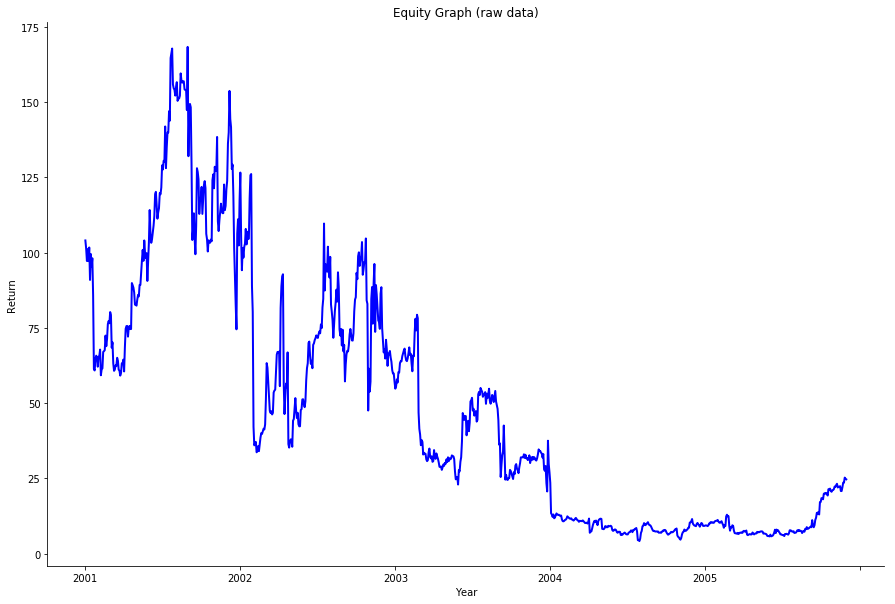

In [26]:
fig, ax  = plt.subplots()

masterdf["Equity Curve"].plot(ax = ax, color = "b", lw = 2, figsize = (15,10))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

x_label_list = range(2000,2006)
x_label_list = np.round(x_label_list)
ax.set_xticklabels(x_label_list)

ax.set_title("Equity Graph (raw data)") 
ax.set_ylabel("Return")
ax.set_xlabel("Year")

plt.show()

## The strategy generally performs well until it hits big losers. Let's try normalizing sentiment and see if that makes a difference.

In [28]:
ticker = file_list[50].split("/")[1]
ticker

'BK'

In [18]:

for i in file_list:
    if i == file_list[0]:
        masterdf2 = pd.read_csv(zipf3.open(i))
        masterdf2.rename(index = str, columns = {"Unnamed: 0": "Date"}, inplace=True)
        masterdf2["Ticker"] = i.split("/")[1]
        masterdf2.drop(masterdf2.columns[1:4],axis=1,inplace=True)
        masterdf2.drop(masterdf2.columns[2:5],axis=1,inplace=True)
        masterdf2.drop(masterdf2.columns[3],axis=1,inplace=True)
        print("master df 2 initialized")
    
    tempdf = pd.read_csv(zipf3.open(i))
    tempdf.rename(index = str, columns = {"Unnamed: 0": "Date"}, inplace=True)
    tempdf["Ticker"] = i.split("/")[1]
    tempdf.drop(tempdf.columns[1:4],axis=1,inplace=True)
    tempdf.drop(tempdf.columns[2:5],axis=1,inplace=True)
    tempdf.drop(tempdf.columns[3],axis=1,inplace=True)
    print(tempdf)
    masterdf2 = pd.merge(masterdf2,tempdf,how="outer")

master df 2 initialized
          Date  Sentiment  Day Return Ticker
0   2001-05-17  -0.408284    0.018947      A
1   2001-08-20  -0.095506   -0.000383      A
2   2002-05-16  -0.021097   -0.005042      A
3   2002-08-19  -0.198758    0.099622      A
4   2002-11-18  -0.105263   -0.007299      A
5   2003-02-21  -0.303030    0.038610      A
6   2003-05-19  -0.156863   -0.036646      A
7   2003-08-18   0.120000    0.031221      A
8   2003-11-17   0.100000    0.005261      A
9   2004-02-17   0.333333    0.011057      A
10  2004-05-17   0.260000    0.002750      A
11  2004-08-12   0.078431   -0.096419      A
12  2004-11-11  -0.098361    0.022700      A
13  2005-02-14   0.177570    0.020391      A
14  2005-05-16   0.243523   -0.013272      A
15  2005-08-15   0.040000    0.021212      A
16  2005-11-14   0.347368    0.003049      A
          Date  Sentiment  Day Return Ticker
0   2002-03-19  -0.086957         NaN     AA
1   2002-04-25   0.060606         NaN     AA
2   2002-07-17  -0.095890      

          Date  Sentiment  Day Return Ticker
0   2001-07-26          0    0.002813    AGN
1   2001-10-24          0   -0.018609    AGN
2   2002-04-22          0   -0.004908    AGN
3   2002-04-30          0    0.009438    AGN
4   2002-07-24          0    0.026201    AGN
5   2002-08-12          0    0.007944    AGN
6   2002-10-24          0   -0.019763    AGN
7   2002-10-31          0   -0.015401    AGN
8   2002-12-18          0   -0.007207    AGN
9   2003-01-29          0   -0.007119    AGN
10  2003-02-25          0    0.014472    AGN
11  2003-04-28          0   -0.019945    AGN
12  2003-04-30          0    0.013952    AGN
13  2003-07-23          0   -0.015328    AGN
14  2003-07-30          0   -0.007463    AGN
15  2003-10-22          0   -0.036512    AGN
16  2003-10-29          0   -0.017857    AGN
17  2004-01-08          0    0.015909    AGN
18  2004-01-12          0   -0.004334    AGN
19  2004-01-28          0   -0.006765    AGN
20  2004-02-26          0    0.005441    AGN
21  2004-0

         Date  Sentiment  Day Return Ticker
0  2003-07-22   0.137931   -0.023249   AMZN
1  2003-10-21   0.118110   -0.006362   AMZN
2  2004-01-27   0.136986   -0.017797   AMZN
3  2004-04-22  -0.032787    0.063330   AMZN
4  2004-07-22   0.109244    0.048513   AMZN
5  2004-10-21   0.168142   -0.000253   AMZN
6  2005-02-02   0.136842   -0.027178   AMZN
7  2005-04-26   0.088235   -0.018307   AMZN
8  2005-07-26   0.165714   -0.012559   AMZN
9  2005-10-25   0.078014   -0.015145   AMZN
          Date  Sentiment  Day Return Ticker
0   2001-05-02   0.155556   -0.020588     AN
1   2002-04-23   0.229630    0.014384     AN
2   2002-07-25   0.118012   -0.010543     AN
3   2002-10-24  -0.005025   -0.049774     AN
4   2003-02-06  -0.067308   -0.010025     AN
5   2003-04-28  -0.048649    0.040590     AN
6   2003-07-24   0.337931   -0.015107     AN
7   2003-10-30   0.264249    0.030286     AN
8   2004-02-05   0.221675    0.024879     AN
9   2004-04-29   0.365854   -0.015789     AN
10  2004-07-20  -0.08

          Date  Sentiment  Day Return Ticker
0   2002-04-18   0.065217    0.033902    AXP
1   2002-07-22  -0.020134   -0.065484    AXP
2   2002-10-28  -0.268012    0.028220    AXP
3   2003-01-27  -0.037344    0.004509    AXP
4   2003-04-24  -0.057751    0.009537    AXP
5   2003-07-28   0.181572   -0.018321    AXP
6   2003-10-27   0.343849   -0.026245    AXP
7   2004-01-26   0.278810    0.019816    AXP
8   2004-04-22   0.377953    0.024203    AXP
9   2004-07-26   0.216730    0.016421    AXP
10  2004-10-25   0.018750   -0.010638    AXP
11  2004-11-15  -0.532847    0.007375    AXP
12  2005-01-24   0.200000    0.010567    AXP
13  2005-02-01   0.550201    0.027149    AXP
14  2005-04-26   0.179283    0.019782    AXP
15  2005-06-07   0.202899    0.011097    AXP
16  2005-07-25   0.224490   -0.006193    AXP
17  2005-10-24   0.090129    0.033160    AXP
          Date  Sentiment  Day Return Ticker
0   2001-05-24   0.244240    0.013198    AZO
1   2001-12-05   0.231441    0.069595    AZO
2   2002-0

         Date  Sentiment  Day Return Ticker
0  2002-04-25   0.035176   -0.002867     BC
1  2002-07-25   0.059459    0.003828     BC
2  2002-10-25   0.120879    0.054545     BC
3  2003-04-24   0.090909    0.029370     BC
          Date  Sentiment  Day Return Ticker
0   2002-03-11  -1.000000    0.000363    BCR
1   2002-04-16  -0.394958   -0.006297    BCR
2   2002-05-08  -0.087719    0.001657    BCR
3   2002-07-17  -0.109244    0.002985    BCR
4   2002-10-16  -0.203252    0.004717    BCR
5   2002-12-13  -0.068966   -0.006993    BCR
6   2003-01-28   0.086093    0.009448    BCR
7   2003-04-15   0.245675   -0.025197    BCR
8   2003-07-16   0.200000   -0.025926    BCR
9   2003-08-13   0.184211   -0.009510    BCR
10  2003-10-15   0.303867    0.000000    BCR
11  2003-11-10  -0.093525   -0.010465    BCR
12  2004-01-28   0.065327   -0.016183    BCR
13  2004-03-09   0.106383    0.007552    BCR
14  2004-04-05   0.232877    0.006113    BCR
15  2004-04-20  -0.012346    0.010076    BCR
16  2004-05-06 

          Date  Sentiment  Day Return Ticker
0   2001-04-26   0.335714   -0.014070    CAH
1   2002-04-23   0.324074   -0.039126    CAH
2   2002-04-24   0.141304   -0.008857    CAH
3   2002-06-14   0.333333    0.034057    CAH
4   2002-08-06   0.330097    0.031858    CAH
5   2002-08-15   0.386364    0.001727    CAH
6   2002-10-22   0.432558    0.033137    CAH
7   2003-01-23   0.405622   -0.016949    CAH
8   2003-04-23   0.222642   -0.051455    CAH
9   2003-07-31   0.451852   -0.079832    CAH
10  2003-10-23   0.338290    0.035721    CAH
11  2004-01-22   0.357143    0.051974    CAH
12  2004-04-22   0.406504    0.020480    CAH
13  2004-05-19   0.312500   -0.004444    CAH
14  2004-06-30  -0.048544    0.007769    CAH
15  2004-10-26  -0.120301    0.016017    CAH
16  2004-12-13   0.005650   -0.006061    CAH
17  2005-02-04   0.103679    0.048477    CAH
18  2005-04-29   0.276423    0.010364    CAH
19  2005-06-27  -0.200000   -0.010174    CAH
20  2005-08-05   0.129412    0.014041    CAH
21  2005-0

          Date  Sentiment  Day Return Ticker
0   2002-05-01   0.069307    0.103827  CMCSA
1   2002-08-01   0.129187   -0.086897  CMCSA
2   2002-10-28   0.034483   -0.004839  CMCSA
3   2003-01-13   0.073446   -0.002896  CMCSA
4   2003-02-27   0.087866    0.055824  CMCSA
5   2003-05-08   0.094488    0.011379  CMCSA
6   2003-07-31   0.482517   -0.006195  CMCSA
7   2003-10-30   0.051383   -0.004174  CMCSA
8   2004-02-11   0.550725   -0.004145  CMCSA
9   2004-04-28   0.013699   -0.045210  CMCSA
10  2004-07-28   0.091837   -0.019566  CMCSA
11  2004-10-27   0.032258    0.008901  CMCSA
12  2005-02-03   0.191257    0.024242  CMCSA
13  2005-04-21   0.084112    0.007812  CMCSA
14  2005-04-28   0.134752   -0.007781  CMCSA
15  2005-08-02   0.062500   -0.004815  CMCSA
16  2005-11-02   0.535211    0.020191  CMCSA
17  2005-11-03   0.172414   -0.008336  CMCSA
          Date  Sentiment  Day Return Ticker
0   2003-01-30   0.033557   -0.049462    CME
1   2003-04-22   0.113043    0.015915    CME
2   2003-0

          Date  Sentiment  Day Return Ticker
0   2001-04-26  -0.157895   -0.030442    CTL
1   2002-03-19  -0.271186    0.004491    CTL
2   2002-04-25  -0.250000    0.007716    CTL
3   2002-05-06  -0.066667   -0.017598    CTL
4   2002-07-25  -0.073930    0.005917    CTL
5   2002-10-24  -0.208122    0.048507    CTL
6   2003-01-30  -0.182796    0.010363    CTL
7   2003-05-01  -0.030000    0.015025    CTL
8   2003-07-31   0.083871    0.019929    CTL
9   2003-10-30  -0.070588   -0.014294    CTL
10  2004-01-29  -0.097087   -0.095315    CTL
11  2004-04-29  -0.034483    0.068877    CTL
12  2004-07-29  -0.025641    0.023715    CTL
13  2004-10-28  -0.125000   -0.073746    CTL
14  2005-02-03  -0.014085   -0.015000    CTL
15  2005-04-28   0.107345   -0.008194    CTL
16  2005-07-28  -0.066667    0.014706    CTL
17  2005-10-27  -0.018182   -0.016605    CTL
          Date  Sentiment  Day Return Ticker
0   2002-04-16   0.251185    0.137834   CTSH
1   2002-07-16  -0.031915    0.079606   CTSH
2   2002-1

          Date  Sentiment  Day Return Ticker
0   2001-05-15  -0.047210   -0.012308     DE
1   2001-11-20  -0.192118   -0.037267     DE
2   2002-05-14  -0.241026    0.005501     DE
3   2002-08-13  -0.007246    0.026667     DE
4   2002-11-19  -0.066667    0.037422     DE
5   2003-02-11  -0.054852    0.010883     DE
6   2003-05-13  -0.048035   -0.027943     DE
7   2003-07-29  -0.083333    0.006024     DE
8   2003-08-12   0.073529    0.042064     DE
9   2003-11-25   0.015544   -0.024762     DE
10  2004-02-17   0.200000   -0.001490     DE
11  2004-02-24  -0.090909   -0.008596     DE
12  2004-04-29   0.157895   -0.024640     DE
13  2004-05-18   0.121212   -0.026165     DE
14  2004-08-03   0.302752   -0.001598     DE
15  2004-08-17  -0.010870   -0.037600     DE
16  2004-10-27   0.243243    0.030179     DE
17  2004-11-23   0.015385   -0.014181     DE
18  2005-02-15  -0.160221   -0.023634     DE
19  2005-02-24  -0.081967    0.027952     DE
20  2005-04-28   0.121495   -0.015093     DE
21  2005-0

          Date  Sentiment  Day Return Ticker
0   2001-12-03  -0.429752         NaN    DYN
1   2001-12-17  -0.208791         NaN    DYN
2   2002-04-25  -0.015974         NaN    DYN
3   2002-04-30   0.050955         NaN    DYN
4   2002-05-28   0.188811         NaN    DYN
5   2002-06-24  -0.126904         NaN    DYN
6   2002-07-30  -0.220000         NaN    DYN
7   2002-11-19  -0.274611         NaN    DYN
8   2003-01-07  -0.112108         NaN    DYN
9   2003-01-31  -0.299492         NaN    DYN
10  2003-04-29  -0.119048         NaN    DYN
11  2003-08-13  -0.023923         NaN    DYN
12  2003-10-30   0.105769         NaN    DYN
13  2004-01-29   0.065327         NaN    DYN
14  2004-04-28   0.069124         NaN    DYN
15  2004-07-28   0.287554         NaN    DYN
16  2004-10-28   0.158879         NaN    DYN
17  2005-02-24   0.294686         NaN    DYN
18  2005-05-09   0.223214         NaN    DYN
19  2005-08-08  -0.047619         NaN    DYN
20  2005-11-08  -0.016949         NaN    DYN
          

          Date  Sentiment  Day Return Ticker
0   2001-05-01  -0.323944   -0.017361      F
1   2001-06-01  -0.193277    0.011934      F
2   2001-06-21  -0.013477    0.055850      F
3   2001-07-03  -0.219512    0.004008      F
4   2001-12-03  -0.057325   -0.035753      F
5   2002-01-17  -0.251397   -0.016722      F
6   2002-02-01  -0.243243   -0.011936      F
7   2002-04-02  -0.525424   -0.016005      F
8   2002-04-08  -0.323353    0.007333      F
9   2002-05-01  -0.182482    0.023168      F
10  2002-05-20   0.207547   -0.004167      F
11  2002-06-03  -0.049645   -0.022034      F
12  2002-07-02  -0.164021    0.014810      F
13  2002-09-04   0.031250    0.005460      F
14  2002-10-01  -0.114504    0.022727      F
15  2002-11-26  -0.047619   -0.005515      F
16  2004-03-23  -0.357488   -0.008462      F
17  2004-03-25  -0.302857    0.010736      F
18  2004-04-01  -0.241830   -0.007396      F
19  2004-04-21  -0.045455    0.019795      F
20  2004-05-03  -0.267974    0.004605      F
21  2004-0

          Date  Sentiment  Day Return Ticker
0   2001-04-26  -0.055556    0.062166   GILD
1   2002-01-18  -0.500000   -0.064865   GILD
2   2002-02-08   0.000000    0.060577   GILD
3   2002-04-30  -0.155844    0.077189   GILD
4   2002-05-02  -0.132075    0.002743   GILD
5   2002-07-24  -0.053892    0.065545   GILD
6   2002-07-31   0.008850    0.050690   GILD
7   2002-08-22  -0.080000    0.023770   GILD
8   2002-09-09  -0.435115    0.020957   GILD
9   2002-10-31   0.175000    0.002887   GILD
10  2002-11-12  -0.321429    0.001676   GILD
11  2002-12-04   0.008696    0.050852   GILD
12  2003-01-30   0.250000    0.008811   GILD
13  2003-04-24  -0.083333    0.054139   GILD
14  2003-07-31   0.159236   -0.007564   GILD
15  2003-10-28  -0.005291    0.026766   GILD
16  2004-01-29   0.157895   -0.011564   GILD
17  2004-04-22   0.224242    0.024567   GILD
18  2004-07-29   0.073171    0.009672   GILD
19  2004-10-21   0.105485   -0.022883   GILD
20  2005-01-27   0.099476   -0.010325   GILD
21  2005-0

          Date  Sentiment  Day Return Ticker
0   2002-10-29  -0.018519   -0.037711    HIG
1   2003-01-28   0.014925    0.023311    HIG
2   2003-05-12  -0.384977    0.152988    HIG
3   2003-05-14   0.034483   -0.003478    HIG
4   2003-05-16  -0.151261    0.033732    HIG
5   2003-08-07   0.029197    0.017143    HIG
6   2003-11-06   0.151724    0.044356    HIG
7   2003-12-01  -0.049180    0.012410    HIG
8   2004-01-29   0.140065   -0.010296    HIG
9   2004-05-05  -0.007557    0.024192    HIG
10  2004-08-05   0.303371   -0.025451    HIG
11  2004-11-05  -0.062857   -0.007236    HIG
12  2005-01-27   0.051546   -0.012666    HIG
13  2005-04-29   0.086957    0.033857    HIG
14  2005-08-05   0.121076    0.025385    HIG
15  2005-11-04   0.056277    0.015961    HIG
          Date  Sentiment  Day Return Ticker
0   2001-04-11   0.161616   -0.035116    HOG
1   2002-04-17  -0.102703   -0.013381    HOG
2   2002-07-17   0.169399   -0.017444    HOG
3   2002-10-16   0.004926    0.010566    HOG
4   2003-0

          Date  Sentiment  Day Return Ticker
0   2001-04-17  -0.204678    0.031287   INTC
1   2001-07-17  -0.126582    0.046552   INTC
2   2001-12-18  -0.313433   -0.009956   INTC
3   2002-04-16   0.034091    0.014787   INTC
4   2002-06-06  -0.415094   -0.018182   INTC
5   2002-06-11   0.096154   -0.056903   INTC
6   2002-07-16  -0.714286   -0.010776   INTC
7   2002-09-05  -0.182796   -0.044276   INTC
8   2002-09-13   0.057971    0.021019   INTC
9   2002-10-15  -0.055556    0.036386   INTC
10  2002-11-18   0.215686   -0.025157   INTC
11  2002-11-21  -0.029703    0.041753   INTC
12  2002-12-05  -0.234043   -0.055306   INTC
13  2003-01-14  -0.004785    0.013092   INTC
14  2003-03-06  -0.348315   -0.009490   INTC
15  2003-04-15  -0.085714    0.000000   INTC
16  2003-06-05  -0.307692    0.035562   INTC
17  2003-07-15   0.101124   -0.013912   INTC
18  2003-08-22   0.318436   -0.027344   INTC
19  2003-10-14   0.131868    0.009419   INTC
20  2003-11-11  -0.029412    0.004812   INTC
21  2003-1

          Date  Sentiment  Day Return Ticker
0   2001-04-17  -0.186813   -0.013274    JPM
1   2001-04-18  -0.016287   -0.020300    JPM
2   2001-07-18  -0.128571    0.000000    JPM
3   2001-12-20  -0.394366   -0.008955    JPM
4   2002-04-16  -0.217391    0.012303    JPM
5   2002-04-17  -0.168919    0.036718    JPM
6   2002-04-26  -0.308271   -0.021259    JPM
7   2002-05-07   0.053140   -0.008872    JPM
8   2002-07-16  -0.201550   -0.013841    JPM
9   2002-07-17  -0.270270   -0.029990    JPM
10  2002-07-24  -0.469880    0.225671    JPM
11  2002-09-17  -0.591398   -0.029279    JPM
12  2002-10-15   0.014085    0.016940    JPM
13  2002-10-16  -0.440789    0.007713    JPM
14  2003-01-02  -0.478261    0.007525    JPM
15  2003-01-16   0.028571   -0.011078    JPM
16  2003-01-22  -0.179856   -0.028324    JPM
17  2003-04-15  -0.029851    0.013580    JPM
18  2003-04-16  -0.110294   -0.037763    JPM
19  2003-07-16  -0.025381   -0.052535    JPM
20  2003-09-05  -0.089362   -0.008698    JPM
21  2003-1

          Date  Sentiment  Day Return Ticker
0   2001-07-18   0.283843   -0.014709     KO
1   2002-04-16   0.391304    0.028441     KO
2   2002-07-17   0.399317   -0.023438     KO
3   2002-10-16   0.310559   -0.056000     KO
4   2003-02-12   0.333333    0.009142     KO
5   2003-04-16   0.083333   -0.018450     KO
6   2003-07-17   0.401042    0.010840     KO
7   2003-10-16   0.451104    0.011009     KO
8   2004-02-11   0.539432    0.003876     KO
9   2004-04-21   0.403101    0.010271     KO
10  2004-07-22   0.328904   -0.001631     KO
11  2004-09-15   0.116466    0.008329     KO
12  2004-10-21   0.072000    0.004580     KO
13  2005-02-16   0.401639   -0.013667     KO
14  2005-04-19   0.323171   -0.005862     KO
15  2005-07-21   0.370892   -0.008572     KO
16  2005-10-20   0.392857   -0.018648     KO
          Date  Sentiment  Day Return Ticker
0   2001-04-30   0.447154    0.008482     KR
1   2001-06-26   0.320574    0.010204     KR
2   2001-12-11   0.114504   -0.055924     KR
3   2002-0

          Date  Sentiment  Day Return Ticker
0   2001-01-25  -0.270718    0.025432    LLY
1   2002-04-15  -0.288889    0.002667    LLY
2   2002-07-18  -0.312500   -0.046365    LLY
3   2002-09-20  -0.048387    0.013676    LLY
4   2002-10-23  -0.311111   -0.012075    LLY
5   2002-11-14   0.244898    0.007973    LLY
6   2002-12-19  -0.132743    0.004823    LLY
7   2003-01-03   0.014286    0.011322    LLY
8   2003-01-17   0.145374   -0.022288    LLY
9   2003-01-23  -0.010870    0.008730    LLY
10  2003-04-22  -0.084577    0.030604    LLY
11  2003-07-24   0.029412   -0.004173    LLY
12  2003-10-22  -0.083333   -0.016505    LLY
13  2004-01-05  -0.208333   -0.002983    LLY
14  2004-01-29  -0.044444    0.024719    LLY
15  2004-04-19  -0.041096    0.012414    LLY
16  2004-07-22  -0.174312    0.009984    LLY
17  2004-09-24  -0.280000    0.002520    LLY
18  2004-10-19  -0.112150   -0.024390    LLY
19  2004-10-21  -0.365854   -0.029856    LLY
20  2004-12-08  -0.200000   -0.000184    LLY
21  2005-0

          Date  Sentiment  Day Return Ticker
0   2002-05-07  -0.044944   -0.065689    MET
1   2002-08-06  -0.139344   -0.015157    MET
2   2002-11-06  -0.107266    0.020307    MET
3   2003-02-11  -0.111801   -0.034510    MET
4   2003-05-06   0.048951    0.021083    MET
5   2003-08-05   0.111111   -0.028125    MET
6   2003-11-04  -0.022026    0.025455    MET
7   2004-02-11   0.032258    0.001133    MET
8   2004-05-04   0.093117   -0.020113    MET
9   2004-07-29   0.092308    0.007943    MET
10  2004-10-28   0.061538   -0.007853    MET
11  2005-01-31   0.070866   -0.006250    MET
12  2005-02-10   0.012658   -0.022800    MET
13  2005-05-04   0.288732    0.049398    MET
          Date  Sentiment  Day Return Ticker
0   2002-04-16  -0.365079    0.000000    MIL
1   2002-07-16  -0.174825    0.070479    MIL
2   2002-10-16  -0.327935    0.000000    MIL
3   2003-01-23  -0.132743    0.008309    MIL
4   2003-04-15  -0.096774    0.005266    MIL
5   2003-07-16  -0.354037    0.005604    MIL
6   2003-1

          Date  Sentiment  Day Return Ticker
0   2002-04-23  -0.290698    0.009262    MRO
1   2002-07-25  -0.075269   -0.025135    MRO
2   2002-10-24  -0.160976   -0.008091    MRO
3   2002-11-14  -0.237705   -0.040686    MRO
4   2003-01-23  -0.170213   -0.009390    MRO
5   2003-04-24  -0.071823    0.002193    MRO
6   2003-05-14  -0.058824    0.008299    MRO
7   2003-07-24  -0.200000    0.005395    MRO
8   2003-10-23  -0.235669   -0.002700    MRO
9   2003-11-04   0.431782   -0.006768    MRO
10  2004-01-27  -0.197674   -0.007205    MRO
11  2004-03-19   0.106719   -0.040395    MRO
12  2004-04-27  -0.046512    0.018551    MRO
13  2004-07-27  -0.145455    0.051143    MRO
14  2004-10-26  -0.402135   -0.017728    MRO
15  2005-01-27   0.065421    0.026663    MRO
16  2005-04-28  -0.210884   -0.008432    MRO
17  2005-07-28   0.093168    0.003231    MRO
18  2005-10-27   0.060976   -0.054785    MRO
          Date  Sentiment  Day Return Ticker
0   2001-12-19  -0.286432    0.042804     MS
1   2002-0

         Date  Sentiment  Day Return Ticker
0  2003-01-30  -0.033333   -0.018132     NI
1  2003-04-29  -0.028571   -0.023980     NI
2  2004-01-30  -0.223529   -0.016854     NI
3  2004-04-30   0.041667   -0.006897     NI
4  2005-02-04   0.303371    0.003915     NI
5  2005-04-29   0.145038    0.021538     NI
6  2005-07-28   0.017857    0.009110     NI
7  2005-11-04  -0.242857   -0.010110     NI
          Date  Sentiment  Day Return Ticker
0   2001-06-28  -0.081081   -0.023721    NKE
1   2001-12-20   0.245763   -0.008479    NKE
2   2002-09-18   0.221519    0.047445    NKE
3   2002-09-20   0.550388    0.005701    NKE
4   2002-12-19   0.194969   -0.013539    NKE
5   2003-03-19   0.184358    0.017059    NKE
6   2003-06-26   0.325843   -0.000878    NKE
7   2003-09-18   0.455738    0.003506    NKE
8   2003-12-18   0.581560    0.011815    NKE
9   2004-03-18   0.516418    0.008136    NKE
10  2004-06-24   0.416000    0.002770    NKE
11  2004-09-20   0.593625    0.001284    NKE
12  2004-12-16   0.

           Date  Sentiment  Day Return Ticker
0    2001-06-18  -0.228700   -0.025607   ORCL
1    2001-07-24   0.213740    0.000000   ORCL
2    2001-10-18  -0.010830    0.040117   ORCL
3    2001-12-13  -0.024155   -0.038033   ORCL
4    2002-03-14  -0.149123   -0.045455   ORCL
5    2002-05-01  -0.098592   -0.048338   ORCL
6    2002-05-16   0.188755    0.033441   ORCL
7    2002-05-22   0.326531    0.009174   ORCL
8    2002-05-23  -0.005405    0.038803   ORCL
9    2002-06-18  -0.022472   -0.012168   ORCL
10   2002-07-08  -0.395349   -0.046107   ORCL
11   2002-07-17  -0.241379    0.003835   ORCL
12   2002-07-18  -0.034965   -0.022374   ORCL
13   2002-07-30   0.070539    0.035677   ORCL
14   2002-08-15  -0.234375    0.000000   ORCL
15   2002-08-20  -0.042471    0.004669   ORCL
16   2002-08-21   0.265306   -0.017352   ORCL
17   2002-09-17  -0.139130   -0.039362   ORCL
18   2002-10-02  -0.565217    0.004837   ORCL
19   2002-10-16  -0.266667    0.010846   ORCL
20   2002-10-17  -0.030568   -0.01

          Date  Sentiment  Day Return Ticker
0   2002-08-22   0.000000   -0.034980   PDCO
1   2002-11-21  -0.050505   -0.099693   PDCO
2   2003-02-20   0.142857    0.034390   PDCO
3   2003-05-22   0.189655    0.016770   PDCO
4   2003-08-20  -0.099099    0.012670   PDCO
5   2003-11-20   0.261146    0.027993   PDCO
6   2004-02-19  -0.022901   -0.029061   PDCO
7   2004-05-20   0.225806   -0.022059   PDCO
8   2004-08-26  -0.144828    0.010121   PDCO
9   2004-11-24   0.062069    0.041001   PDCO
10  2005-02-24   0.007194    0.040635   PDCO
11  2005-05-26   0.358025   -0.031117   PDCO
12  2005-08-25   0.042857   -0.009553   PDCO
13  2005-11-23  -0.120482    0.013551   PDCO
          Date  Sentiment  Day Return Ticker
0   2001-04-18  -0.270588   -0.019718    PEG
1   2002-04-17  -0.271605    0.022793    PEG
2   2002-07-17  -0.348416   -0.027147    PEG
3   2002-10-29  -0.264706    0.059846    PEG
4   2003-01-28  -0.248677    0.022857    PEG
5   2003-04-16  -0.125683   -0.013867    PEG
6   2003-0

          Date  Sentiment  Day Return Ticker
0   2002-04-23  -0.364706    0.016520    PNW
1   2002-07-23  -0.221719   -0.055873    PNW
2   2002-10-28  -0.533835    0.002867    PNW
3   2003-02-04  -0.222749    0.004248    PNW
4   2003-05-02  -0.154639    0.023175    PNW
5   2003-07-28  -0.348837    0.010420    PNW
6   2003-10-24  -0.268657    0.020904    PNW
7   2004-01-29  -0.281250    0.001274    PNW
8   2004-05-07  -0.372263   -0.020619    PNW
9   2004-07-29  -0.392857   -0.002494    PNW
10  2004-08-19  -0.393258   -0.007425    PNW
11  2004-10-22  -0.152542   -0.003075    PNW
12  2005-01-28  -0.224806   -0.004503    PNW
13  2005-04-27  -0.313131    0.023614    PNW
14  2005-07-27  -0.320755   -0.001970    PNW
15  2005-10-27  -0.422819   -0.036623    PNW
         Date  Sentiment  Day Return Ticker
0  2001-04-19  -0.435897         NaN    PPG
1  2003-10-16   0.166667         NaN    PPG
2  2004-01-15   0.248120         NaN    PPG
3  2004-04-15   0.423729         NaN    PPG
          Date 

          Date  Sentiment  Day Return Ticker
0   2001-04-17   0.011111   -0.003648     RF
1   2002-04-16   0.142857    0.011024     RF
2   2002-07-16   0.219251   -0.000892     RF
3   2002-10-15  -0.215909    0.019845     RF
4   2003-01-14   0.145098    0.011527     RF
5   2003-04-15   0.130952    0.018530     RF
6   2003-07-15  -0.242604    0.001401     RF
7   2003-07-17   0.000000    0.006154     RF
8   2003-10-14   0.019108    0.004385     RF
9   2003-10-16  -0.011364    0.004400     RF
10  2004-01-13   0.091837   -0.007923     RF
11  2004-01-16   0.180723   -0.001361     RF
12  2004-04-13   0.075269   -0.016025     RF
13  2004-04-16   0.136986    0.004598     RF
14  2004-07-13   0.068182   -0.001323     RF
15  2004-07-16   0.261682    0.004013     RF
16  2004-10-15   0.187817    0.028245     RF
17  2004-10-19  -0.212598    0.003526     RF
18  2005-01-18   0.062762   -0.006293     RF
19  2005-04-15   0.229167    0.003695     RF
20  2005-04-19   0.305164    0.001861     RF
21  2005-0

          Date  Sentiment  Day Return Ticker
0   2002-04-18  -0.045113    0.008553    SHW
1   2002-07-18  -0.217391    0.000000    SHW
2   2002-10-22  -0.041379   -0.005837    SHW
3   2003-02-06   0.094488   -0.029790    SHW
4   2003-04-22  -0.315789    0.031273    SHW
5   2003-07-22  -0.261438    0.040696    SHW
6   2003-10-28  -0.023256    0.023457    SHW
7   2004-02-05   0.157143   -0.010219    SHW
8   2004-04-29  -0.012658   -0.019838    SHW
9   2004-07-22   0.105263   -0.015792    SHW
10  2004-10-21   0.156463   -0.017586    SHW
11  2005-02-03  -0.010753    0.033187    SHW
12  2005-04-21  -0.188235   -0.014170    SHW
13  2005-07-21  -0.043062   -0.009026    SHW
14  2005-10-25  -0.211618   -0.041176    SHW
          Date  Sentiment  Day Return Ticker
0   2001-04-25   0.372549    0.006968   SIAL
1   2002-04-24   0.016129    0.063877   SIAL
2   2002-07-24   0.165354    0.111635   SIAL
3   2002-10-23   0.362832   -0.034520   SIAL
4   2003-02-12   0.172881   -0.019762   SIAL
5   2003-0

          Date  Sentiment  Day Return Ticker
0   2001-05-30  -0.314079    0.009631    STI
1   2002-04-10  -0.039711    0.003430    STI
2   2002-07-10  -0.227941   -0.025878    STI
3   2002-07-17   0.131034   -0.007189    STI
4   2002-10-09  -0.102881   -0.021907    STI
5   2002-10-17   0.022422   -0.007871    STI
6   2003-01-08  -0.267176   -0.013038    STI
7   2003-01-16   0.064677   -0.007054    STI
8   2003-04-10  -0.120275    0.068270    STI
9   2003-04-17  -0.084444    0.003036    STI
10  2003-05-29   0.397436   -0.013022    STI
11  2003-07-10  -0.146853   -0.004756    STI
12  2003-07-17   0.140496   -0.003608    STI
13  2003-10-09   0.153605   -0.014520    STI
14  2003-10-16   0.224490    0.004590    STI
15  2004-01-12   0.090278   -0.012142    STI
16  2004-01-16   0.232877   -0.002196    STI
17  2004-04-08   0.037313   -0.001281    STI
18  2004-04-16   0.452915   -0.003021    STI
19  2004-05-10   0.354839   -0.034224    STI
20  2004-07-12  -0.095588    0.015385    STI
21  2004-0

          Date  Sentiment  Day Return Ticker
0   2002-04-18   0.062857    0.005638      T
1   2002-04-23   0.195652   -0.002233      T
2   2002-05-09   0.084211   -0.003180      T
3   2002-07-23  -0.090278   -0.023061      T
4   2002-07-29   0.009709   -0.012806      T
5   2002-08-07   0.233533   -0.029434      T
6   2002-10-23   0.056106    0.023762      T
7   2002-10-24  -0.271795   -0.033898      T
8   2002-11-15   0.108108    0.031954      T
9   2002-12-23  -0.473684   -0.002849      T
10  2003-01-28  -0.071429    0.024000      T
11  2003-03-06   0.086538   -0.006326      T
12  2003-04-23   0.181250    0.063467      T
13  2003-04-24   0.287805    0.019005      T
14  2003-05-05   0.031111   -0.019992      T
15  2003-05-06   0.052023    0.006356      T
16  2003-07-21   0.167702   -0.041442      T
17  2003-07-24   0.050000   -0.039175      T
18  2003-08-06   0.236715    0.009471      T
19  2003-10-21   0.233831    0.016166      T
20  2003-11-10  -0.102703    0.023519      T
21  2003-1

          Date  Sentiment  Day Return Ticker
0   2001-10-17  -0.304659   -0.057953    TXN
1   2002-04-15  -0.042017   -0.003721    TXN
2   2002-07-22   0.066667   -0.058753    TXN
3   2002-10-21  -0.153846    0.005285    TXN
4   2002-12-12   0.203883   -0.007964    TXN
5   2003-01-22  -0.057592    0.010638    TXN
6   2003-04-15  -0.079755    0.066254    TXN
7   2003-05-15  -0.113772   -0.006085    TXN
8   2003-06-10  -0.448276    0.008408    TXN
9   2003-07-21  -0.243446   -0.025613    TXN
10  2003-09-09  -0.164384   -0.007059    TXN
11  2003-10-20  -0.021277    0.015427    TXN
12  2003-12-08  -0.210526   -0.016028    TXN
13  2004-01-26   0.114583    0.025321    TXN
14  2004-03-08  -0.157233   -0.033175    TXN
15  2004-04-14   0.010989   -0.009326    TXN
16  2004-06-07  -0.140845    0.024609    TXN
17  2004-07-20  -0.106918    0.036190    TXN
18  2004-09-08  -0.265306    0.011278    TXN
19  2004-10-18  -0.052174    0.001900    TXN
20  2004-12-07  -0.128834   -0.018824    TXN
21  2005-0

          Date  Sentiment  Day Return Ticker
0   2001-07-26   0.157407   -0.001482   VRSN
1   2001-10-25   0.147982    0.094378   VRSN
2   2001-12-13   0.071429   -0.003092   VRSN
3   2002-04-25  -0.309237    0.021277   VRSN
4   2002-07-10  -0.563218    0.006048   VRSN
5   2002-07-25   0.020576   -0.070796   VRSN
6   2002-10-24   0.083700   -0.001348   VRSN
7   2003-01-23   0.147410    0.003824   VRSN
8   2003-04-24   0.184358   -0.052385   VRSN
9   2003-07-24   0.257143   -0.052711   VRSN
10  2003-10-23   0.166667   -0.026613   VRSN
11  2004-01-29   0.200000   -0.050267   VRSN
12  2004-04-22   0.175000    0.015104   VRSN
13  2004-05-24   0.062500    0.017748   VRSN
14  2004-07-22   0.239437    0.032165   VRSN
15  2004-10-20   0.283951   -0.031264   VRSN
16  2005-01-10   0.250000    0.000324   VRSN
17  2005-01-26   0.350000    0.028812   VRSN
18  2005-04-20   0.292135    0.009438   VRSN
19  2005-07-20   0.307087    0.009749   VRSN
20  2005-09-29  -0.107143   -0.002896   VRSN
21  2005-1

          Date  Sentiment  Day Return Ticker
0   2001-04-17  -0.464968   -0.017143     WY
1   2001-12-20  -0.468085    0.012830     WY
2   2002-04-24  -0.218391   -0.021852     WY
3   2002-07-23  -0.155738    0.010046     WY
4   2002-10-22  -0.311828   -0.013548     WY
5   2002-11-20  -0.585714    0.009524     WY
6   2002-12-12  -0.150000   -0.008848     WY
7   2003-01-22  -0.140097    0.003902     WY
8   2003-04-25  -0.045455   -0.020298     WY
9   2003-07-25  -0.185520    0.002315     WY
10  2003-10-24  -0.104000   -0.004938     WY
11  2004-01-23  -0.241877   -0.036112     WY
12  2004-04-23  -0.106383    0.007413     WY
13  2004-07-23   0.049808   -0.007775     WY
14  2004-10-22  -0.244980   -0.036741     WY
15  2005-01-21  -0.305439   -0.015732     WY
16  2005-04-21  -0.246512   -0.017625     WY
17  2005-07-21   0.033962    0.022139     WY
18  2005-10-21  -0.383513    0.003393     WY
          Date  Sentiment  Day Return Ticker
0   2002-04-26   0.041667    0.025847      X
1   2002-0

In [19]:
masterdf2.dropna(inplace=True)
masterdf2 = masterdf2.sort_values("Date")
masterdf2.head()

,Date,Sentiment,Day Return,Ticker
7773,2001-01-10,0.175966,0.040600,YHOO
4293,2001-01-25,-0.270718,0.025432,LLY
5446,2001-03-19,-0.229814,0.041214,PAYX
606,2001-03-27,-0.074236,-0.040541,APOL
886,2001-04-03,0.323944,-0.039329,BBY


In [20]:
masterdf2["Rolling Standardized Sentiment"] = (masterdf2["Sentiment"] - masterdf2["Sentiment"].rolling(
    window=60,min_periods=60,center=False).mean()) / masterdf2["Sentiment"].rolling(
    window=60,min_periods=60,center=False).std()

In [21]:
masterdf2.dropna(inplace=True)
masterdf2['Standardized Signal (T = 1)'] = masterdf2['Rolling Standardized Sentiment'].apply(
    lambda x: 1 if x >= 1 else (-1 if x<= -1 else 0))

In [22]:
masterdf2= masterdf2.replace(0,np.nan)
masterdf2.dropna(inplace=True)
masterdf2["Standardized Strategy Return (T = 1)"] = masterdf2["Standardized Signal (T = 1)"] * masterdf2["Day Return"]
masterdf2.head()

,Date,Sentiment,Day Return,Ticker,Rolling Standardized Sentiment,Standardized Signal (T = 1),Standardized Strategy Return (T = 1)
4494,2001-04-19,0.356322,-0.065941,MAT,2.001018,1.0,-0.065941
2432,2001-04-19,0.285141,0.059335,EBAY,1.585880,1.0,0.059335
1402,2001-04-19,0.205128,-0.042781,CCE,1.228102,1.0,-0.042781
4870,2001-04-19,0.252747,0.033885,MSFT,1.452814,1.0,0.033885
4750,2001-04-20,-0.271739,-0.025033,MRK,-1.066610,-1.0,0.025033


In [23]:
StrategyReturn = masterdf2.drop(masterdf2.columns[1:6],axis=1)
StrategyReturn.set_index("Date",inplace=True)
StrategyReturn = StrategyReturn.groupby(StrategyReturn.index).sum()

In [24]:
equity = 100
equityCurve = []
for i in StrategyReturn["Standardized Strategy Return (T = 1)"]:
    equity = equity + (equity * i)
    equityCurve.append(equity)
print(equity)

StrategyReturn["Standardized (T = 1) Equity Curve"] = equityCurve

428.35010344534555


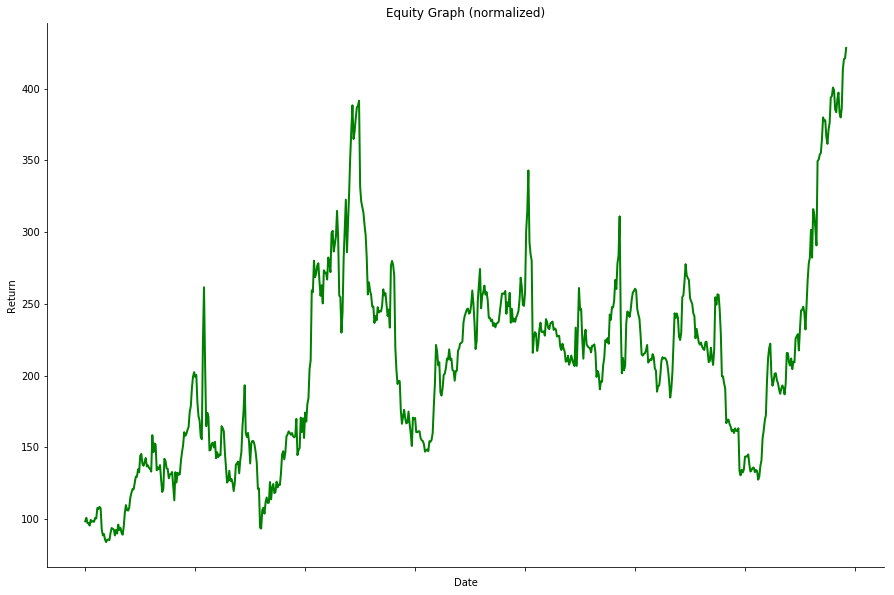

In [27]:
fig, ax  = plt.subplots()

StrategyReturn["Standardized (T = 1) Equity Curve"].plot(ax = ax, color = "g", lw = 2, figsize = (15,10))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title("Equity Graph (normalized)") 
ax.set_ylabel("Return")
#ax.set_xlabel("Year")

plt.show()

# Conclusion

The returns when the sentiment score and signals are standardized are quite impressive - 400%+ return over 4 years. The strategy itself is incredibly volatile, but that is to be expected since trading on earnings day is inherent to the strategy. 

The sentiment-analyzer was developed with the intent of accurately determining how a positive or negative outlook on market news can have a measurable impact on stock price movements. Going forward, we're hopeful that the sentiment analyzer will have other useful applications. For example, the analyzer would allow us to trade on tweets from President Trump that might impact the global economy or comments by social influencers like Rihanna or Kylie Jenner that have the capacity to drive down the value of consumer facing companies such as Snap Inc.  

Now that we know that the platform performs well with the test data utilized in this project, we can make furhter improvements and tweaks such as identifying the "Big Losers" and "Big Winners," and analyzing those specic trades to better understand the characteristics of the anomalies and avoid them in the future. 